<a href="https://colab.research.google.com/github/Tolexrules/CS474-Labs/blob/master/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [0]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [0]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving marriott.jpg to marriott (2).jpg

Upload Style Image


Saving my_little_pony.jpg to my_little_pony (3).jpg
Content Path: <_io.BytesIO object at 0x7f9c216b9990>
Style Path: <_io.BytesIO object at 0x7f9c216b9620>


In [0]:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):  
          m.inplace = False          
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [0]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

content_layers = [19]
style_layers = [0, 2, 5, 7, 12, 14, 19, 21, 26]

vgg_content = VGGIntermediate(content_layers)
vgg_style = VGGIntermediate(style_layers)
vgg_content.cuda()
vgg_style.cuda()

content_feature_layers = vgg_content(content_image)
style_feature_layers = vgg_style(style_image)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**
* Display the style tensor and content tensor transformed back to an image

**DONE:**


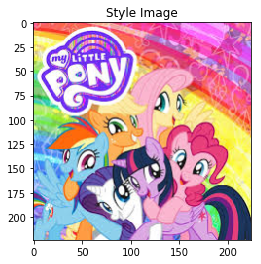

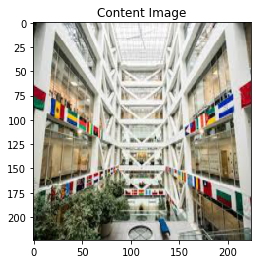

In [0]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')

___

### Part 3
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [0]:
def gram_matrix(input):
  batch_size, num_feature_maps, height, width = input.size()
  feature_map = input.view(batch_size * num_feature_maps, height * width)
  feature_map = torch.mm(feature_map, feature_map.t())
  return feature_map / (batch_size * num_feature_maps * height * width)
  
class ContentLoss(nn.Module):
  def __init__(self, content_image):
    super(ContentLoss, self).__init__()
    self.content_image = content_image.detach()
    
  def forward(self, input):
    self.loss = F.mse_loss(input, self.content_image)
    return self.loss / 2
    
class StyleLoss(nn.Module):
  def __init__(self, style_feature_map):
    super(StyleLoss, self).__init__()
    self.style_gram = gram_matrix(style_feature_map).detach()
      
  def forward(self, input):
    batch_size, num_feature_maps, height, width = input.size()
    generated_gram = gram_matrix(input)
    self.loss = F.mse_loss(generated_gram, self.style_gram)
    return self.loss

content_loss_layers = []
for content_layer in content_feature_layers:
  content_loss_layers.append(ContentLoss(content_feature_layers[content_layer]))

style_loss_layers = []
for style_layer in style_feature_layers:
  style_loss_layers.append(StyleLoss(style_feature_layers[style_layer]))


___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



Content Loss: tensor(0., device='cuda:0', grad_fn=<AddBackward0>)
Style Loss tensor(0.1591, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss tensor(15912.7275, device='cuda:0', grad_fn=<AddBackward0>)
Content Loss: tensor(90.5918, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss tensor(0.0046, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss tensor(545.6285, device='cuda:0', grad_fn=<AddBackward0>)
Content Loss: tensor(89.8447, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss tensor(370.9999, device='cuda:0', grad_fn=<AddBackward0>)
Content Loss: tensor(88.6655, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss tensor(0.0022, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss tensor(307.5255, device='cuda:0', grad_fn=<AddBackward0>)
Content Loss: tensor(87.6929, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss tensor(0.0018, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss tensor(264.3650, device='c

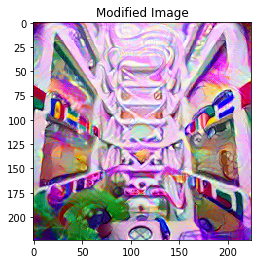

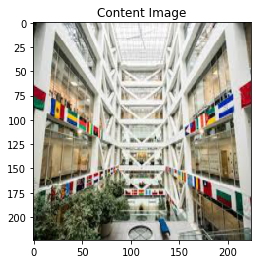

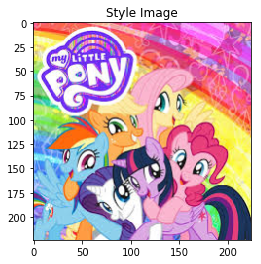

In [0]:
def scope(content_weight, style_weight):
  content_copy = copy.deepcopy(content_image)
  optimizer = optim.Adam([content_copy.requires_grad_()], 1e-2)
  
  content_losses = []
  style_losses = []
    
  for x in range(500):
    content_copy.data.clamp_(0, 1)
    optimizer.zero_grad()
    
    content_loss = 0
    style_loss = 0
    
    vgg_generated_content = vgg_content(content_copy)
    vgg_generated_style = vgg_style(content_copy)
    
    for index in range(len(content_layers)):
      content_loss_layer = content_loss_layers[index]
      generated_content_layer = vgg_generated_content[content_layers[index]]
      content_loss += content_loss_layer(generated_content_layer)
    
    for index in range(len(style_layers)):
      style_loss_layer = style_loss_layers[index]
      generated_style_layer = vgg_generated_style[style_layers[index]]
      style_loss += (style_loss_layer(generated_style_layer)) / (4)
    
    loss = content_loss * content_weight + style_loss * style_weight
    loss.backward()
    optimizer.step()
    
    if x % 50 == 0:
      print('Content Loss: ' + str(content_loss))
      print('Style Loss ' + str(style_loss))
      print('Total Loss ' + str(loss))
  
  plt.figure()
  display(content_copy, title='Modified Image')
  plt.figure()
  display(content_image, title='Content Image')
  plt.figure()
  display(style_image, title='Style Image')
  
scope(1, 100000)

### Part 5

**TODO:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**DONE:**

Equation 1: The Content Loss of the generated image x, when compared to the original image p, at layer l
is equal to half of the sum of the squared differences of the activation values of the feature maps F and P, which correlate to x and p respectively, at the indeces i and j.

Equation 3: The Feature Correlation Matrix, also called the Gram Matrix, at layer l and indeces i and j is equal to the sum of all dot product values between the ith and jth rows of the Feature map F.

Equation 4: The Style Loss of the generated image x, when compared to the original image a, at layer l is equal to the constant 1/(4 * Nl^2 * Ml^2), where Nl is the number of filters at l and Ml is the height * width of the feature map at layer l, multiplied the sum of the squared differences between the Gram Matrices G and A, which are computed using Equation 3 for x and a respectively, at layer l for all indeces i and j.

Equation 5: The Total Style Loss is equal to the sum of the products of some constant weight and the Style loss for the generated image x when compared to the original image a (equation 4), for all layers indexed by l.